In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import datetime
import pandas as pd
%matplotlib inline

This notebook grabs historic match data from the free API https://www.football-data.org and prepares some graphs summarizing latest results.

The next cell is an example cell to run an API query. You can see all possible examples at https://www.football-data.org/documentation/quickstart

In [2]:
# headers = { 
#     'X-Auth-Token': '13b41abb78284b7482713f316a0e3578',
#     "X-Unfold-Goals": 'true'
#            }
# uri = 'http://api.football-data.org/v4/matches/327125/head2head?limit=50'
# response = requests.get(uri, headers=headers)
# response.json()

The next cells queries the API for a specific league and season. You can change these but the licensed token doesn't have many. You can look at "PL" for Premier League, or "CL" for Champions League, or "PD" for La Liga. You can see all league codes here: https://docs.football-data.org/general/v4/lookup_tables.html, but only Tier 1 are available, as described here: https://www.football-data.org/coverage

In [3]:
# See API documentation for options available: https://docs.football-data.org/general/v4/index.html
league = 'PL' 
seasons = ['2020','2021','2022','2023']

headers = { 
    'X-Auth-Token': '13b41abb78284b7482713f316a0e3578',
           }

In [4]:
def parse_match(json_response):
    """
    This function simply grabs the data from the API and formats it into a dictionary
    """
    matches = []
    for m in json_response:
        match = {}
        match['league'] = m['competition']['name']
        match['season_start'] = m['season']['startDate']
        match['season_end'] = m['season']['endDate']
        match['date'] = m['utcDate']
        match['status'] = m['status']
        match['matchday'] = m['matchday']
        match['home_team'] = m['homeTeam']['name']
        match['home_team_short'] = m['homeTeam']['shortName']
        match['home_team_code'] = m['homeTeam']['tla']
        match['away_team'] = m['awayTeam']['name']
        match['away_team_short'] = m['awayTeam']['shortName']
        match['away_team_code'] = m['awayTeam']['tla']
        match['home_team_score'] = m['score']['fullTime']['home']
        match['away_team_score'] = m['score']['fullTime']['away']
        match['home_team_halfscore'] = m['score']['halfTime']['home']
        match['away_team_halfscore'] = m['score']['halfTime']['away']
        matches.append(match)
    return matches

In [5]:
matches_list = []
for season in seasons:
    uri = 'https://api.football-data.org/v4/competitions/{}/matches?season={}'.format(league, season)
    response = requests.get(uri, headers=headers)
    matches_dict = parse_match(response.json()['matches'])
    matches_list.extend(matches_dict)

Identifying the next week's games

In [6]:
# We grab today's date
today = datetime.datetime.now()
today.date()

datetime.date(2023, 8, 14)

In [8]:
# We define a DataFrame with the data from the API
df = pd.DataFrame(matches_list)
df['date'] = pd.to_datetime(df['date']).dt.date
df['season_start'] = pd.to_datetime(df['season_start'])
df['season_end'] = pd.to_datetime(df['season_end'])
df['season'] = df['season_start'].dt.year
df.head(3)

,league,season_start,season_end,date,status,matchday,home_team,home_team_short,home_team_code,away_team,away_team_short,away_team_code,home_team_score,away_team_score,home_team_halfscore,away_team_halfscore,season
0,Premier League,2020-09-12,2021-05-23,2020-09-12,FINISHED,1,Fulham FC,Fulham,FUL,Arsenal FC,Arsenal,ARS,0.0,3.0,0.0,1.0,2020
1,Premier League,2020-09-12,2021-05-23,2020-09-12,FINISHED,1,Crystal Palace FC,Crystal Palace,CRY,Southampton FC,Southampton,SOU,1.0,0.0,1.0,0.0,2020
2,Premier League,2020-09-12,2021-05-23,2020-09-12,FINISHED,1,Liverpool FC,Liverpool,LIV,Leeds United FC,Leeds United,LEE,4.0,3.0,3.0,2.0,2020


In [9]:
# We separate a DataFrame for games before today, and for games after today
previous_games = df[(df['date'] <= today.date()) & (df['status']=="FINISHED")]
upcoming_games = df[(df['date'] >= today.date()) & (df['status']!="FINISHED")]
print("Number of past games:",len(previous_games))
print("Number of future games:",len(upcoming_games))
upcoming_games.head(3)

Number of past games: 1150
Number of future games: 370


,league,season_start,season_end,date,status,matchday,home_team,home_team_short,home_team_code,away_team,away_team_short,away_team_code,home_team_score,away_team_score,home_team_halfscore,away_team_halfscore,season
1150,Premier League,2023-08-11,2024-05-19,2023-08-18,TIMED,2,Nottingham Forest FC,Nottingham,NOT,Sheffield United FC,Sheffield Utd,SHE,NaN,NaN,NaN,NaN,2023
1151,Premier League,2023-08-11,2024-05-19,2023-08-19,POSTPONED,2,Luton Town FC,Luton Town,LUT,Burnley FC,Burnley,BUR,NaN,NaN,NaN,NaN,2023
1152,Premier League,2023-08-11,2024-05-19,2023-08-19,TIMED,2,Fulham FC,Fulham,FUL,Brentford FC,Brentford,BRE,NaN,NaN,NaN,NaN,2023


In [10]:
# We filter only the games for the next week
margin = datetime.timedelta(days = 7)
last_week_df = previous_games[previous_games['date']>(today.date()-margin)]
next_week_df = upcoming_games[upcoming_games['date']<(today.date()+margin)]
next_week_df

,league,season_start,season_end,date,status,matchday,home_team,home_team_short,home_team_code,away_team,away_team_short,away_team_code,home_team_score,away_team_score,home_team_halfscore,away_team_halfscore,season
1150,Premier League,2023-08-11,2024-05-19,2023-08-18,TIMED,2,Nottingham Forest FC,Nottingham,NOT,Sheffield United FC,Sheffield Utd,SHE,NaN,NaN,NaN,NaN,2023
1151,Premier League,2023-08-11,2024-05-19,2023-08-19,POSTPONED,2,Luton Town FC,Luton Town,LUT,Burnley FC,Burnley,BUR,NaN,NaN,NaN,NaN,2023
1152,Premier League,2023-08-11,2024-05-19,2023-08-19,TIMED,2,Fulham FC,Fulham,FUL,Brentford FC,Brentford,BRE,NaN,NaN,NaN,NaN,2023
1153,Premier League,2023-08-11,2024-05-19,2023-08-19,TIMED,2,Liverpool FC,Liverpool,LIV,AFC Bournemouth,Bournemouth,BOU,NaN,NaN,NaN,NaN,2023
1154,Premier League,2023-08-11,2024-05-19,2023-08-19,TIMED,2,Wolverhampton Wanderers FC,Wolverhampton,WOL,Brighton & Hove Albion FC,Brighton Hove,BHA,NaN,NaN,NaN,NaN,2023
1155,Premier League,2023-08-11,2024-05-19,2023-08-19,TIMED,2,Tottenham Hotspur FC,Tottenham,TOT,Manchester United FC,Man United,MUN,NaN,NaN,NaN,NaN,2023
1156,Premier League,2023-08-11,2024-05-19,2023-08-19,TIMED,2,Manchester City FC,Man City,MCI,Newcastle United FC,Newcastle,NEW,NaN,NaN,NaN,NaN,2023
1157,Premier League,2023-08-11,2024-05-19,2023-08-20,TIMED,2,Aston Villa FC,Aston Villa,AVL,Everton FC,Everton,EVE,NaN,NaN,NaN,NaN,2023
1158,Premier League,2023-08-11,2024-05-19,2023-08-20,TIMED,2,West Ham United FC,West Ham,WHU,Chelsea FC,Chelsea,CHE,NaN,NaN,NaN,NaN,2023


In [11]:
# We prepare a gadget to view and select a match we want to know more about
next_week_games_names = list(map(' vs '.join, zip(next_week_df['home_team_short'], next_week_df['away_team_short'])))
next_week_games_index = list(next_week_df.index)
next_week_games = [ (game, index) for game, index in zip(next_week_games_names, next_week_games_index) ]
game = widgets.Dropdown(
    options=next_week_games,
    value=next_week_games[0][1],
    description='Game Selected:',
    disabled=False,
)
display(game)

Dropdown(description='Game Selected:', options=(('Nottingham vs Sheffield Utd', 1150), ('Luton Town vs Burnley…

In [12]:
team_a = next_week_df.loc[game.value]['home_team']
team_a_short = next_week_df.loc[game.value]['home_team_short']
team_b = next_week_df.loc[game.value]['away_team']
team_b_short = next_week_df.loc[game.value]['away_team_short']
print ("Home team selected:",team_a)
print("Away team selected:",team_b)

Home team selected: Nottingham Forest FC
Away team selected: Sheffield United FC


Analyzing previous matches

The assumption here is that if you played this team before, it can help predict the result of the next match, depending on whether you're home and away.

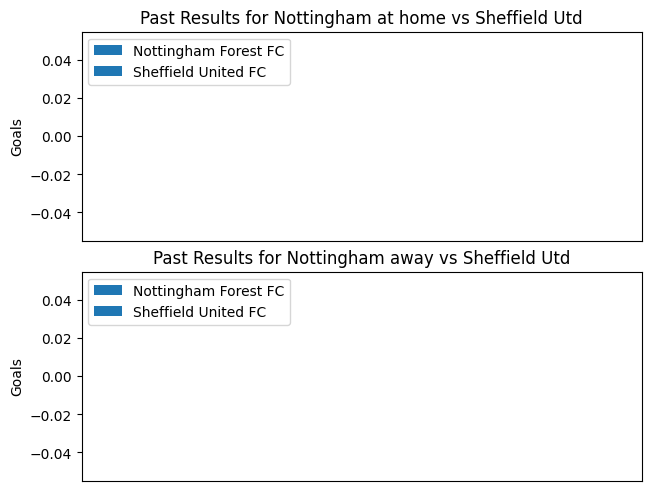

In [13]:
# Identifying previous games from the game selected
home_a = previous_games[(previous_games['home_team']==team_a) & (previous_games['away_team']==team_b)]
home_b = previous_games[(previous_games['home_team']==team_b) & (previous_games['away_team']==team_a)]

# Grabbing the data to plot
team_a_home_season = home_a['season']
team_a_away_season = home_b['season']

home_graph = {
    team_a: home_a['home_team_score'],
    team_b: home_a['away_team_score']
}
away_graph = {
    team_a: home_b['home_team_score'],
    team_b: home_b['away_team_score']
}

# Plotting the data
fig, (ax1,ax2) = plt.subplots(2,1, layout="constrained")
x = np.arange(len(team_a_home_season))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in home_graph.items():
    offset = width * multiplier
    graph = ax1.bar(x + offset, measurement, width, label=attribute, tick_label=team_a_home_season)
    ax1.bar_label(graph, label_type='center')
    multiplier += 1

x = np.arange(len(team_a_away_season))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
for attribute, measurement in away_graph.items():
    offset = width * multiplier
    graph = ax2.bar(x + offset, measurement, width, label=attribute, tick_label=team_a_away_season)
    ax2.bar_label(graph, label_type='center')
    multiplier += 1

ax1.set_title("Past Results for {} at home vs {}".format(team_a_short, team_b_short))
ax1.set_ylabel("Goals")
ax1.legend(loc='upper left')
ax2.set_title("Past Results for {} away vs {}".format(team_a_short, team_b_short))
ax2.set_ylabel("Goals")
ax2.legend(loc='upper left')

plt.show()

### Analyzing current teams streaks

The assumprion here is that if a team is on a streak, it is more likely that it will continue that streak that randomly changing it on any given game. So, if you are losing the last matches, you are probably on a slum and will probably lose the next match too.

In [51]:
# to do: need to verify the assumption above.

### Analyzing game importance for each team

The assumption here is that not every game is of equal importance. If winning a game can place you above the relegation line, you most likely want to win that game more, maybe giving you an extra for the next game.